In [1]:
import os
import csv
import json

import numpy as np
import matplotlib.pyplot as plt

import sacrebleu
import soundfile as sf

def read_logs(path):
    logs = []
    with open(path, "r") as r:
        for l in r.readlines():
            l = l.strip()
            if l != "":
                logs.append(json.loads(l))
    return logs

def read_wav(wav_path):
    wav_path, offset, duration = wav_path.split(':')
    offset = int(offset)
    duration = int(duration)
    source, rate = sf.read(wav_path, start=offset, frames=duration)
    return source, rate

def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

def write_tsv(samples, tsv_path):
    with open(tsv_path, "w") as w:
        writer = csv.DictWriter(
            w,
            samples[0].keys(),
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        writer.writeheader()
        writer.writerows(samples)

# Examine the DPO training set

In [2]:
samples = read_tsv("/compute/babel-6-13/xixu/train.tsv")

In [17]:
def fix_format(raw_str):
    # Remove the outer quotes
    cleaned_str = raw_str.strip('"')

    # Remove the extra quotes around the array
    if cleaned_str.startswith('['):
        cleaned_str = cleaned_str[1:-1]

    # Split on '", "' to get individual elements
    elements = cleaned_str.split('", "')

    # Clean up each element
    elements = [e.strip('"').encode().decode('unicode_escape') for e in elements]

    return elements

In [16]:
print(samples[0]['trajectory'])

['', '当你向一位', '国家元首问问题的时候是很奇妙的， “', '你们国家最', '珍贵', '的资源是什么？', '', '', '” 他们不会第一时间回答是儿童。但是', '当你说', '是儿童时， 他们几乎会', '立刻', '认同你的说法。', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [19]:
print(fix_format(samples[0]['sampling']))

['这太神奇了，', '当你遇到一个', '国家元首， 你问他，“什么是', '你最', '珍贵的', '自然资源？” 他会说，“那是我们的森林。”', '他们不会说，“那是我们的儿童。”', '在', '一开始， 他们不会这么说。', '然后当你说，', '“儿童”， 他们会几乎', '立刻', '同意你。', '', '', '', '', '', '', '', '我们今天的旅程是', '和', '', '', '哥伦比亚国防部长一起的。', '哥伦比亚的总统，', '军队的指挥官， 和', '警察局的指挥官， 以及', '我们将要降落在', '650', '个平板电脑上。', '给儿童，', '他们有着', '没有', '电视， 没有', '电话， 并且有着', '一个', '被隔离的社区。', '', '在过去的四十年里， 他们与世界其他地方隔绝。', '', '重要的', '是，传递', '平板电脑给这些', '地区，']


In [22]:
from IPython.display import Audio
Audio(read_wav('/compute/babel-14-5/siqiouya/en-zh/data/train/wav/ted_423.wav:0:691200')[0], rate=16000)


# Update training set with forward translation

In [25]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_st_zh.tsv")
complement_samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/comet_0.50_complement_tower.tsv")

In [26]:
len(samples), len(complement_samples)

(356850, 76230)

In [27]:
samples[0], complement_samples[0]

({'id': 'ted_1_0',
  'audio': '/compute/babel-14-5/siqiouya/en-zh/data/train/wav/ted_1.wav:1608160:107519',
  'n_frames': '107519',
  'speaker': 'spk.1',
  'src_text': 'we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville.',
  'tgt_text': '我们驱车从纳什维尔的家开到 我们在东边50里外的一个小农场--',
  'src_lang': 'en',
  'tgt_lang': 'zh'},
 {'id': 'ted_420_153',
  'src_text': "I work on the thing that kills more people than anything else kills -- I work on aging -- and I'm interested in doing something about it, as we'll all hear tomorrow.",
  'translation': '我研究的是杀死人数最多的东西，也就是让人们老去的问题，我想要做点什么，明天大家都会听到。'})

In [23]:
comp_indices = set()
for x in complement_samples:
    id = x['id'].strip()
    if id in comp_indices:
        print(x)
    comp_indices.add(id)

{'id': 'ted_558_72', 'src_text': 'The challenge: to figure out what it will take to actually do something that makes a significant and sustainable difference.', 'translation': '挑战：要想真正做出有意义的持久改变，需要做些什么？'}
{'id': 'ted_666_94', 'src_text': 'That accounts for the same phenomena as the original myth.', 'translation': '这与原先的神话中的相同现象相符。'}
{'id': 'ted_833_9', 'src_text': 'If I go out in the open ocean environment, virtually anywhere in the world, and I drag a net from 3,000 feet to the surface, most of the animals -- in fact, in many places, 80 to 90 percent of the animals that I bring up in that net -- make light.', 'translation': '如果我在世界上任何地方的公海环境中拖着一个深度为 3000 英尺的网从水下浮到水面，大部分动物——事实上，在许多地方，我在网中带上水的动物中有 80% 到 90%——会发出光。'}
{'id': 'ted_1909_62', 'src_text': 'Hot stuff!', 'translation': '热门内容!'}
{'id': 'ted_2121_112', 'src_text': "Well, if you're there  thinking, in old power, this won't happen to us.", 'translation': '如果你在想，在老式的电力系统中，这种事情不会发生。'}
{'id': 'ted_2321_102', 'src_text': 'That makes a 

In [28]:
id2pair = {}
for x in complement_samples:
    id2pair[x['id'].strip()] = (x['src_text'].strip(), x['translation'].strip())

In [29]:
indices = set(x['id'].strip() for x in samples)

In [30]:
comp_indices = set(x['id'].strip() for x in complement_samples)

In [31]:
len(comp_indices & indices), len(comp_indices)

(76222, 76222)

In [32]:
cnt = 0
for x in samples:
    if x['id'].strip() in id2pair:
        cnt += 1
cnt

76222

In [3]:
from IPython.display import Audio
Audio(read_wav('/compute/babel-14-5/siqiouya/en-zh/data/train/wav/ted_423.wav:1704960:691200')[0], rate=16000)

In [40]:
for x in samples:
    id = x['id'].strip()
    if id in comp_indices:
        x['src_text'] = id2pair[id][0]
        x['tgt_text'] = id2pair[id][1]

In [42]:
write_tsv(samples, "/compute/babel-14-5/siqiouya/en-zh/train_ft.tsv")

# BLEU on MWERSEGMENT Output

In [51]:
import os
root = "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/simul-results-full/seg3840_beam1_ms0/tmp"

In [56]:
n_doc = len(os.listdir(root)) // 3

In [77]:
hyps = []
refs = []
hyps_full = []
refs_full = []
for i in range(n_doc):
    with open(os.path.join(root, 'hyp.{}.seg'.format(i)), 'r') as r:
        hyps_doc = r.read().strip().split('\n')
    with open(os.path.join(root, 'ref.{}'.format(i)), 'r') as r:
        refs_doc = r.read().strip().split('\n')
    hyps_doc = [''.join(h.split(' ')) for h in hyps_doc]
    refs_doc = [''.join(r.split(' ')) for r in refs_doc]
    hyps.extend(hyps_doc)
    refs.extend(refs_doc)

    hyps_full.append(' '.join(hyps_doc))
    refs_full.append(' '.join(refs_doc))

In [78]:
import sacrebleu

In [79]:
sacrebleu.corpus_bleu(hyps, [refs], tokenize='zh')

BLEU = 3.35 19.4/4.7/1.7/0.8 (BP = 1.000 ratio = 1.025 hyp_len = 76040 ref_len = 74184)

In [86]:
hyps[10], refs[10]

('到负责人了，并且被要求进去，去救房主的狗', '先到了总指挥身边他被分配到杀进火场去拯救屋主的小狗')

In [80]:
print(hyps_full[0])

在纽约，我是一家非营利性组织的负责 人，叫做罗宾汉。 在我们的社区，志愿者们提供了高水平技能的人员，必须尽早到达消防现场才能进行任何行动。 我记得我的第一次火灾。 我是第二个志愿者到达的，所以我有很大的机会能参与进去。 但是，还是和其他志愿者竞赛到达负责人那里去找出我们 的任务是什么。当我找到负责人时，他正在和房主进行着一场非常有吸引力的谈话，她肯定是有生以来最糟糕的一天 。那是半夜，她站在外面在倾泻的雨下，在一个遮阳伞底下，在睡衣里，赤着脚。 她的房子在燃烧。其他的志愿者们，比我先到的那个，我们叫他莱克斯·路德。他 已经找 到负责人了，并且被要求进去，去救房主的狗 。那个狗，我被它的嫉妒震惊了。 这里有几个律师，一个财务经理，在他余生中都可以告诉人们他进去救了狗。只是因为他比我快了五秒钟。 好吧，我是下一个，负责 人把我推过去 ，说，“贝索，我需要你去进屋子，我需要你上楼梯，穿过火场。我需要你给这位女士带一双鞋。” 我发誓。 所以，不是完 全像我所希望的那样，但是我还是去了。上楼梯，穿过走廊，穿越正在灭火的消防员，他们差不多已经把火扑灭了。进去了主卧室去拿一双鞋。现在， 我知道你们在想什么。但是我不是一个英雄。（笑声） 我把我的工资拿回去，在楼下我遇到了我的死敌，和那只宝贵的狗，在门口。 我们把我们的宝贝带到外面，给了房主。毫无意外的，他收到了更多的关注 ，而不是我的。几周后，部门收到了房主的一封信，感谢我们在救火时表现出的勇敢。 她特别提到我们的善行，还提到有人救了她的狗。你知 道，在罗宾汉组织的职务，和我作为志愿消防员的职务，我见证了很多慷慨和善行，但我也见证了很多的勇气和鼓励，在个体层面。 你们知道我学到了什么吗？ 它们都很重要。所以 当我环顾这个屋子，看到那些已经取得成就的人或者正在努力的人，他们都取得了非凡的成功。我想提醒大家：不要等待。 不要等到你赚了第一百万，才去改变别人的生活。 如果你有东西可以捐赠，就现在去做。在食 物银行做义工，清理一个社区的公园。 做一个导师。 不是每一天都能给我们机会，去改变别人的生活。但是每一天都能给我们一个机会，去改变一个人的生活。所以加入进 来吧！拯救那些鞋子！ 谢谢。但 是——（掌声）在某个地方，有一个医生可以透视未来。有一个护士可以立刻看到每个病人的过去。因为整个医院都在一起，有一个家庭可以现在就轻松呼吸。有些地方

In [81]:
print(refs_full[0])

在纽约，我是“罗宾汉”非营利机构发展部门的主管 在我消灭贫穷之余，我也灭火我是志愿消防居的副指挥 在我们的小镇在一个志愿者都是成功人士的地方你必须要很早到现场才有可能加入战况 我记得我第一场火 我是第二个到现场的志愿者很有可能可以进火场 但你还得跑赢其它志愿者先找到总指挥让他分配工作给你 当我好不容易找到总指挥他正全神贯注地和屋主讨论她显然正经历人生中最糟糕的一天 当时是大半夜她站在滂沱大雨中穿着睡衣、打赤脚、撑着伞她的房子正在熊熊燃烧 另外一个比我先来一步的志愿者就叫他LexLuther（超人中的反派）好了 （笑声） 先到了总指挥身边他被分配到杀进火场去拯救屋主的小狗 小狗哎！我嫉妒死了 这个律师或财务经理终身都可以告诉别人他深入火场救出一条活生生的小狗就因为他比我早到五秒 好吧，接下来轮到我了 总指挥叫我过去 他说，“Bezos，我需要你杀进火场我需要你上楼，越过火焰我需要你为这位女士拿双鞋。“ （笑声） 是真的，我发誓 这不是我心中描绘的图像但我去了上楼，走到走廊底，穿过那些”真正的“消防员他们差不多已经把火熄灭了我走进主卧室，拿了一双鞋 我知道你在想什么但我非英雄 我把我的任务带下楼在前门遇见那位早我五秒的先生和他救出的那条狗 我们带着我们的宝藏走向前门毫无意外的他比我获得更多关注 几个礼拜后我们部门收到从屋主来的一封信谢谢我们的拯救她家的义勇行为 她特别提到一件温馨的细节甚至有人为她拿来一双鞋 无论是我在“罗宾汉”的工作或是我身为志愿消防员的副业我目睹许多非常慷慨的善行我同时也目睹一个人的勇气和慈悲能带来多大的不同 你知道我学到什么？ 它们都一样重要。 当我环顾四周这些成功的或正要成功的人士你们都有着令人激赏的成就我想在这里提醒你们：不要等待 不要等待你赚到第一个一百万才开始改变别人的生活 如果你有什么可以给予现在就开始付出 无论是供应穷人食物 做个榜样 不是每一天我们都有机会拯救他人的生命但每一天我们都有机会影响他人的生命 来吧：救那双鞋。 谢谢各位 BrunoGiussani：Mark，Mark，回来 谢谢各位


In [82]:
sacrebleu.corpus_bleu(hyps_full, [refs_full], tokenize='zh')

BLEU = 30.45 75.6/42.8/22.2/12.0 (BP = 1.000 ratio = 1.024 hyp_len = 76040 ref_len = 74281)

# Debug instances

In [35]:
# samples = read_logs("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/simul-results-full/cache4000_seg960_beam1_ms0/instances.log.corrected")
samples = read_logs("/home/siqiouya/work/sllama/debug-streamllama/instances.log")

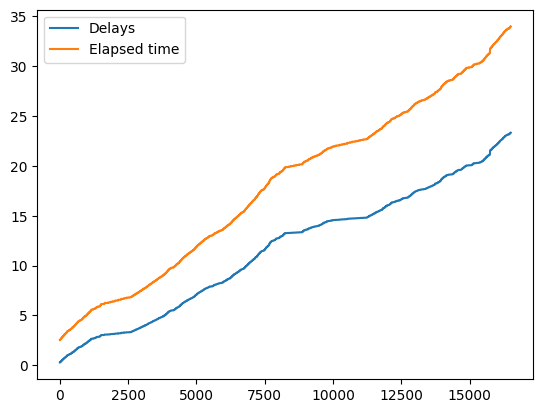

In [37]:
idx = 0
delays = np.array(samples[idx]['delays'])
elapsed = np.array(samples[idx]['elapsed'])
plt.plot(delays / 1000 / 60, label='Delays')
plt.plot(elapsed / 1000 / 60, label='Elapsed time') 
plt.legend()

Text(0, 0.5, 'Per step generation cost (ms)')

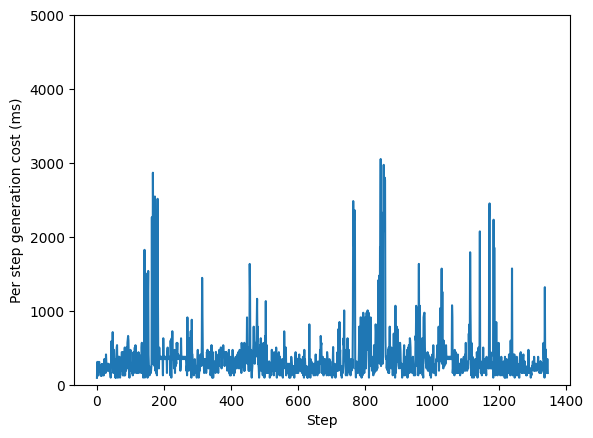

In [39]:
delays_diff = delays[1:] - delays[:-1]
elapsed_diff = elapsed[1:] - elapsed[:-1]
delays_diff = delays_diff[delays_diff > 0]
elapsed_diff = elapsed_diff[elapsed_diff > 0]

plt.plot(elapsed_diff - delays_diff)
plt.ylim(0, 5000)
plt.xlabel('Step')
plt.ylabel('Per step generation cost (ms)')
# plt.yscale('log')

/tmp/ipykernel_1643056/2439543530.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Running average # of tokens generated per step')

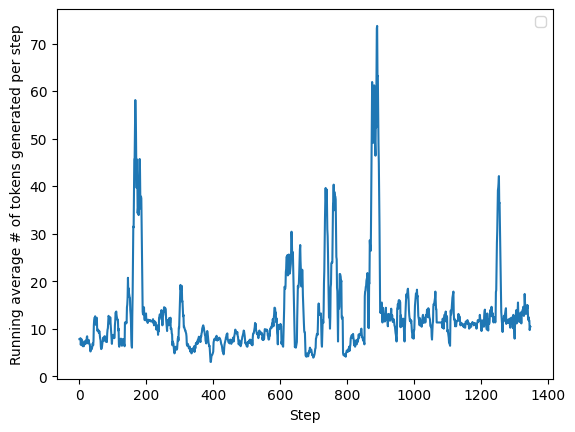

In [26]:
n_token = []
cnt = 0
for i in range(1, len(elapsed)):
    if elapsed[i] == elapsed[i - 1]:
        cnt += 1
    else:
        n_token.append(cnt)
        cnt = 1
sum(n_token)

nocache_n_token = []
cnt = 0
for i in range(1, len(nocache_elapsed)):
    if nocache_elapsed[i] == nocache_elapsed[i - 1]:
        cnt += 1
    else:
        nocache_n_token.append(cnt)
        cnt = 1
sum(nocache_n_token)

running_avg = np.convolve(n_token, np.ones(10)/10, mode='valid')
nocache_running_avg = np.convolve(nocache_n_token, np.ones(10)/10, mode='valid')
plt.plot(running_avg)
# plt.plot(nocache_running_avg, label='No cache')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Running average # of tokens generated per step')

In [18]:
with open("/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0-bi/last.ckpt/offline_beam1/tst-COMMON/hyp", "r") as r:
    hyps = r.read().strip().split("\n")

In [19]:
hyps = [(int(h.split("\t")[0]), h.split("\t")[1]) for h in hyps]

In [20]:
hyps = sorted(hyps)

In [21]:
segmented_samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/tst-COMMON.tsv")

In [22]:
for i in range(len(segmented_samples)):
    segmented_samples[i]['idx'] = i

In [23]:
segmented_samples = sorted(segmented_samples, key=lambda x: (int(x['id'].split('_')[1]), int(x['audio'].split(':')[1])))

In [29]:
ted_id = int(segmented_samples[0]['id'].split('_')[1])
full_hyps = []
full_refs = []
full_hyp = ""
full_ref = ""
for i, s in enumerate(segmented_samples):
    cur_ted_id = int(s['id'].split('_')[1])
    if cur_ted_id != ted_id:
        full_hyps.append(full_hyp)
        full_refs.append(full_ref)
        full_hyp = ""
        full_ref = ""
        ted_id = cur_ted_id        
    full_hyp += hyps[s['idx']][1] + '\n'
    full_ref += s['tgt_text'] + '\n'
full_hyps.append(full_hyp)
full_refs.append(full_ref)

In [31]:
print(full_refs[0])

在纽约，我是“罗宾汉”非营利机构 发展部门的主管
在我消灭贫穷之余，我也灭火 我是志愿消防居的副指挥
在我们的小镇 在一个志愿者都是成功人士的地方 你必须要很早到现场 才有可能加入战况
我记得我第一场火
我是第二个到现场的志愿者 很有可能可以进火场
但你还得跑赢其它志愿者 先找到总指挥 让他分配工作给你
当我好不容易找到总指挥 他正全神贯注地 和屋主讨论 她显然正经历人生中最糟糕的一天
当时是大半夜 她站在滂沱大雨中 穿着睡衣、打赤脚、撑着伞 她的房子正在熊熊燃烧
另外一个比我先来一步的志愿者 就叫他Lex Luther （超人中的反派）好了
（笑声）
先到了总指挥身边 他被分配到 杀进火场去拯救屋主的小狗
小狗哎！我嫉妒死了
这个律师或财务经理 终身都可以告诉别人 他深入火场 救出一条活生生的小狗 就因为他比我早到五秒
好吧，接下来轮到我了
总指挥叫我过去
他说，“Bezos，我需要你杀进火场 我需要你上楼，越过火焰 我需要你为这位女士拿双鞋。 “
（笑声）
是真的，我发誓
这不是我心中描绘的图像 但我去了 上楼，走到走廊底，穿过那些”真正的“消防员 他们差不多已经把火熄灭了 我走进主卧室，拿了一双鞋
我知道你在想什么 但我非英雄
我把我的任务带下楼 在前门遇见那位早我五秒的先生 和他救出的那条狗
我们带着我们的宝藏走向前门 毫无意外的 他比我获得更多关注
几个礼拜后 我们部门收到从屋主来的一封信 谢谢我们的拯救她家的 义勇行为
她特别提到一件温馨的细节 甚至有人为她拿来一双鞋
无论是我在“罗宾汉”的工作 或是我身为志愿消防员的副业 我目睹许多非常慷慨的 善行 我同时也目睹一个人的勇气和慈悲 能带来多大的不同
你知道我学到什么？
它们都一样重要。
当我环顾四周 这些成功的 或正要成功的人士 你们都有着令人激赏的成就 我想在这里提醒你们： 不要等待
不要等待你赚到第一个一百万 才开始改变别人的生活
如果你有什么可以给予 现在就开始付出
无论是供应穷人食物
做个榜样
不是每一天我们都有机会 拯救他人的生命 但每一天我们都有机会影响他人的生命
来吧：救那双鞋。
谢谢各位
Bruno Giussani：Mark，Mark，回来
谢谢各位



In [7]:
bleu = sacrebleu.BLEU(tokenize='zh')

In [32]:
hyps = full_hyps[0].split("\n")
refs = full_refs[0].split("\n")
sacrebleu.corpus_bleu(
    hyps, [refs], tokenize='zh'
)

BLEU = 16.41 45.5/22.2/12.0/6.0 (BP = 1.000 ratio = 1.221 hyp_len = 993 ref_len = 813)

In [35]:
hyps = full_hyps[:1]
refs = full_refs[:1]
sacrebleu.corpus_bleu(
    hyps, [refs], tokenize='zh'
)

BLEU = 18.10 59.3/26.4/12.1/5.7 (BP = 1.000 ratio = 1.221 hyp_len = 993 ref_len = 813)

# Build Full TED tst-COMMON

In [4]:
import os
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [2]:
root = '/compute/babel-14-5/siqiouya/en-zh/'
split = 'tst-COMMON'

In [4]:
samples = read_tsv(os.path.join(root, split + '.tsv'))

In [7]:
def key_func(x):
    _, offset, _ = x['audio'].split(':')
    offset = int(offset)

    ted_id = int(x['id'].split('_')[1])

    return (ted_id, offset)

In [8]:
sorted_samples = sorted(
    samples, 
    key=key_func
)

In [28]:
ted_id = -1
document = ""
documents = []
for x in sorted_samples:
    cur_ted_id = int(x['id'].split('_')[1])
    if cur_ted_id != ted_id:
        documents.append((ted_id, document))
        ted_id = cur_ted_id
        document = x['tgt_text']
    else:
        document += ' ' + x['tgt_text']
documents.append((ted_id, document))
documents = documents[1:]

In [32]:
samples[0]

{'id': 'ted_1096_0',
 'audio': '/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav/ted_1096.wav:1603360:22720',
 'n_frames': '22720',
 'speaker': 'spk.1096',
 'src_text': 'The captain waved me over.',
 'tgt_text': '总指挥叫我过去',
 'src_lang': 'en',
 'tgt_lang': 'zh'}

In [33]:
with open(os.path.join(root, split + '_full.source'), 'w') as w_source, open(os.path.join(root, split + '_full.target'), 'w') as w_target:
    for ted_id, document in documents:
        w_source.write(os.path.join("/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav/", f"ted_{ted_id}.wav") + '\n')
        w_target.write(document + '\n')

# Debug Beam Search

In [1]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
from collections import Counter

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
import transformers
import soundfile as sf

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

from train.options import (
    add_speech_encoder_args,
    add_simuleval_args,
    add_gen_args
)
from model.speech_encoder import (
    SpeechEncoderHuBERTRope,
    SpeechEncoderW2V2RoPE,
    SpeechEncoderW2VBERT2
)
from train.dataset import (
    DEFAULT_SPEECH_PATCH_TOKEN,
    DEFAULT_SPEECH_START_TOKEN,
    DEFAULT_SPEECH_END_TOKEN
)

[2025-01-16 02:19:02,959] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `log2f@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fesetround@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fege

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

speech_encoder_args = [
    "/data/user_data/siqiouya/runs/pretrained/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",
    
    48,
    500,
    model.model.embed_tokens.embedding_dim,
    None,
    False,
]
speech_encoder = SpeechEncoderW2V2RoPE(*speech_encoder_args).eval()
speech_encoder.to(dtype=model.dtype, device=model.device)

length_shrink_func = speech_encoder._get_feat_extract_output_lengths

model.model.speech_encoder = speech_encoder
model.preprocess(tokenizer=tokenizer)

state_dict = torch.load("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v2.2/last.ckpt/pytorch_model.bin", map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
model.model.inference = True

You are using a model of type llama to instantiate a model of type SpeechLlama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Patching with block size 48 and xpos False


/home/siqiouya/work/fairseq/fairseq/checkpoint_utils.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, map_location=torch.device("cpu"))
/home/siqi

In [4]:
source, rate = sf.read("/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav_split/ted_1096_11.wav")
segment_size = 960 * 16 * 2
source = source[:segment_size]

In [5]:
from IPython.display import Audio
Audio(source, rate=rate)

In [26]:
source = torch.tensor(source)
sp_seg_frame = int(48 // 4 * 0.08 * 16000)
if source.size(0) % sp_seg_frame != 0:
    n_pad = sp_seg_frame - source.size(0) % sp_seg_frame
    source = torch.cat([source, torch.zeros(n_pad).to(source)], dim=0)
offset = torch.zeros(79 + 320).to(source)
source = torch.cat([offset, source], dim=0)        
# old_src_len = states.src_len
# states.src_len = source.size(0)
# source = source[old_src_len:]

speech_batch = source.unsqueeze(0).to(device=model.device, dtype=model.dtype)
n_frames = torch.tensor([source.size(0)], dtype=torch.long).to(model.device)
speech_lens = length_shrink_func(n_frames)

/tmp/ipykernel_3209182/1415434830.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source)


In [27]:
speech_batch

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16)

In [28]:
speech_batch.size(), n_frames, speech_lens  

(torch.Size([1, 46479]),
 tensor([46479], device='cuda:0'),
 tensor([36], device='cuda:0'))

In [49]:
messages = []
messages.append(
        {
            "role": "system",
            "content": f"Translate the following speech from English to Chinese."
        }
    )
messages.append(
    {
        "role": "user",
        "content": 12 * DEFAULT_SPEECH_PATCH_TOKEN
    }
)
messages.append(
    {
        "role": "assistant",
        "content": "在我",
    }
)
messages.append(
    {
        "role": "user",
        "content": 12 * DEFAULT_SPEECH_PATCH_TOKEN
    }
)


messages.append(
    {
        "role": "assistant",
        "content": "",
    }
)

In [50]:
input_ids = tokenizer.apply_chat_template(
    [messages],
    return_tensors='pt',
    padding=True, 
    truncation=False, 
    add_special_tokens=False
)[:, :-1].cuda()

In [51]:
input_ids

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,  28573,    279,
           2768,   8982,    505,   6498,    311,   8620,     13, 128009, 128006,
            882, 128007,    271, 128256, 128256, 128256, 128256, 128256, 128256,
         128256, 128256, 128256, 128256, 128256, 128256, 128009, 128006,  78191,
         128007,    271,  19000,  37046, 128009, 128006,    882, 128007,    271,
         128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
         128256, 128256, 128256, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0')

In [52]:
model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=input_ids,
    speech_batch=speech_batch,
    src_lengths=n_frames,
    after_lens=speech_lens,
    do_sample=False,
    top_p=1.0,
    temperature=1.0,
    num_beams=4,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    return_legacy_cache=False,
    output_scores=True,
    use_cache=True,
)

In [53]:
print(tokenizer.decode(outputs.sequences[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Translate the following speech from English to Chinese.<|eot_id|><|start_header_id|>user<|end_header_id|>

<sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><|eot_id|><|start_header_id|>assistant<|end_header_id|>

在我<|eot_id|><|start_header_id|>user<|end_header_id|>

<sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><|eot_id|><|start_header_id|>assistant<|end_header_id|>

<|end_of_text|>


In [54]:
input_ids[0, :57 + 1]

tensor([128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
            25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
           220,   1627,  10263,    220,   2366,     19,    271,  28573,    279,
          2768,   8982,    505,   6498,    311,   8620,     13, 128009, 128006,
           882, 128007,    271, 128256, 128256, 128256, 128256, 128256, 128256,
        128256, 128256, 128256, 128256, 128256, 128256, 128009, 128006,  78191,
        128007,    271,  19000,  37046], device='cuda:0')

In [56]:
outputs.past_key_values[0][0][0, 0][56]

tensor([ 6.1562, -1.6406,  3.5781, -2.1250,  2.2344,  0.2148, -2.4844,  1.7969,
         1.8984, -0.6992,  0.0781, -1.5391,  1.2422,  0.0195,  1.5391, -1.9609,
         1.0234,  1.7656, -0.2363, -0.1680,  1.5781, -1.0625, -2.7344,  2.6250,
        -1.7109, -1.1562, -1.2422,  1.7344,  0.0771, -1.1094,  0.9258,  1.3906,
         0.6523,  0.9766, -1.3828,  0.9219, -0.9258, -0.0486,  2.6562, -0.7383,
        -2.2969,  0.8477, -3.4375,  0.0422, -0.0481, -2.1250, -2.4688,  2.3125,
         2.2188, -1.9922,  1.6797,  2.2812, -1.9453, -1.1797, -0.5977, -1.4062,
         1.5234, -2.8125, -1.1094, -0.7344,  0.2793, -1.3906,  0.0153, -1.4453,
        -1.6094,  3.3281,  0.7109,  0.8984,  1.4219, -1.8828,  0.8555,  1.1250,
        -0.6914,  0.8828, -1.7109, -1.3438, -1.5156, -1.2422, -2.0781,  0.1875,
         2.0312, -1.3516, -0.2871,  2.0156,  0.0000, -0.1387,  1.9141, -1.6719,
         1.5078, -1.7500,  0.2207, -2.8281, -1.3047,  2.0781, -1.7031,  0.6406,
         0.1914, -3.5312, -0.4824,  1.26

In [17]:
speech_batch = speech_batch.float()
speech_encoder.encode_speech(
    speech_batch, n_frames
)[0][:, :12]

tensor([[[-0.3926, -0.5178,  0.1924,  ..., -0.6745,  0.5486, -0.3668],
         [-0.0844,  0.0713,  0.0134,  ..., -0.0153,  0.3642, -0.1541],
         [ 0.1676,  0.1603, -0.2341,  ..., -0.0378,  0.1535,  0.0355],
         ...,
         [ 0.7369, -0.0205, -0.4962,  ..., -0.2084, -0.0579,  0.6461],
         [ 0.7138, -0.0887, -0.3594,  ..., -0.3467,  0.0486,  0.6202],
         [-0.0546,  0.0935, -0.0467,  ..., -0.1150,  0.0311, -0.0098]]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
speech_encoder.encode_speech(
    speech_batch[:, :15759], n_frames * 0 + 15759
)

(tensor([[[-0.3926, -0.5178,  0.1924,  ..., -0.6745,  0.5486, -0.3668],
          [-0.0844,  0.0713,  0.0134,  ..., -0.0152,  0.3642, -0.1541],
          [ 0.1676,  0.1602, -0.2341,  ..., -0.0378,  0.1534,  0.0355],
          ...,
          [ 0.7369, -0.0206, -0.4961,  ..., -0.2085, -0.0579,  0.6461],
          [ 0.7138, -0.0887, -0.3594,  ..., -0.3467,  0.0486,  0.6202],
          [-0.0546,  0.0935, -0.0467,  ..., -0.1149,  0.0310, -0.0098]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 <model.speech_encoder.W2V2RoPECache at 0x7f0402064a60>)

# Evaluate

In [11]:
import os
import numpy as np
from sacrebleu import BLEU

In [5]:
dirname = "/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0/last.ckpt/offline_beam4/tst-COMMON/"

In [17]:
with open(os.path.join(dirname, 'hyp'), 'r') as f:
    hyps = [l.split('\t')[1].strip() for l in f.readlines() if len(l.split('\t')) > 1]
with open(os.path.join(dirname, 'ref'), 'r') as f:
    refs = [l.split('\t')[1].strip() for l in f.readlines() if len(l.split('\t')) > 1]

In [18]:
hyps = np.array(hyps)
refs = np.array(refs)

In [19]:
scorer = BLEU(tokenize='zh')

In [20]:
lens = [(len(r), i) for i, r in enumerate(refs)]
sorted_lens = sorted(lens, key=lambda x: x[0])
sorted_indices = [si[1] for si in sorted_lens]

In [37]:
scorer.corpus_score(
    hyps[sorted_indices[-1000:]].tolist(),
    [refs[sorted_indices[-1000:]].tolist()],
)

BLEU = 7.62 64.7/36.5/22.0/13.8 (BP = 0.262 ratio = 0.428 hyp_len = 19068 ref_len = 44599)

In [40]:
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [41]:
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/{}.tsv".format("train")
full_samples = read_tsv(tsv_path)
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/{}.tsv".format("comet_0.50")
half_samples = read_tsv(tsv_path)

In [42]:
len(full_samples), len(half_samples)

(356850, 280619)

In [48]:
full_duration = np.array([s["n_frames"] for s in full_samples], dtype=np.int32) / 16000
half_duration = np.array([s["n_frames"] for s in half_samples], dtype=np.int32) / 16000

In [49]:
import matplotlib.pyplot as plt

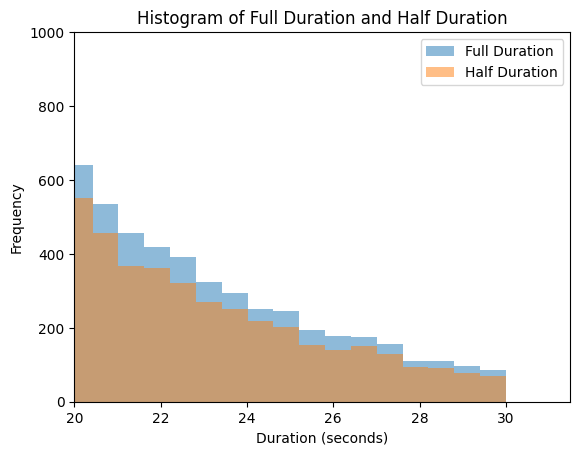

In [55]:
plt.hist(full_duration, bins=50, alpha=0.5, label='Full Duration')
plt.hist(half_duration, bins=50, alpha=0.5, label='Half Duration')
plt.xlim(20)
plt.ylim(0, 1000)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Duration and Half Duration')
plt.show()

In [58]:
full_refs = np.array([len(s["tgt_text"]) for s in full_samples])
half_refs = np.array([len(s["tgt_text"]) for s in half_samples])

In [63]:
(full_refs > 100).sum(), (half_refs > 100).sum()

(4607, 3954)

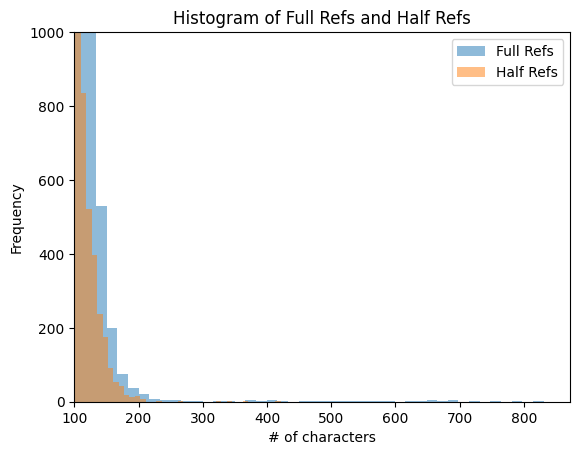

In [61]:
plt.hist(full_refs, bins=50, alpha=0.5, label='Full Refs')
plt.hist(half_refs, bins=50, alpha=0.5, label='Half Refs')
plt.xlabel('# of characters')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Refs and Half Refs')
plt.xlim(100)
plt.ylim(0, 1000)
plt.show()

In [64]:
de_samples = read_tsv("/compute/babel-6-17/xixu/datasets/must-c-v1.0/en-de/train.tsv")

In [67]:
de_refs = np.array([len(s["tgt_text"].split(' ')) for s in de_samples])

In [68]:
de_refs

array([ 6, 15, 12, ...,  6,  6,  9])

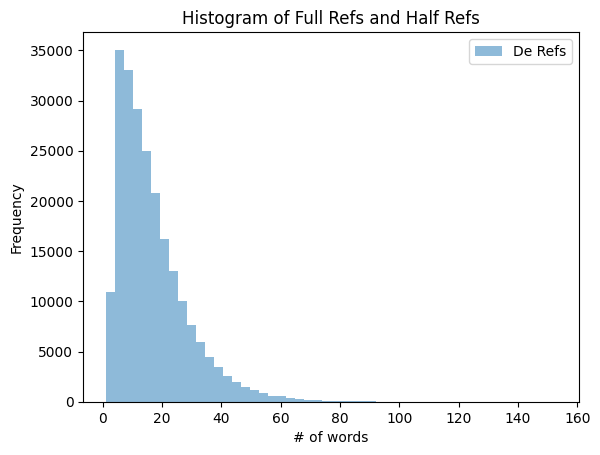

In [72]:
plt.hist(de_refs, bins=50, alpha=0.5, label='De Refs')
plt.xlabel('# of words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Refs and Half Refs')

plt.show()

# Llama 3.1 Instruct

In [1]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from collections import Counter

from IPython.display import Audio

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

[2025-01-03 15:19:50,164] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `log2f@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fesetround@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fege

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

You are using a model of type llama to instantiate a model of type SpeechLlama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
m1 = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
    {"role": "assistant", "content": ""}
]
m2 = [
    {"role": "system", "content": "Translate the following speech from English to Chinese."},
    {"role": "user", "content": "Who are you?"},
]

In [4]:
tokenizer.apply_chat_template(
    [m1, m2], 
    return_tensors='pt',
    padding=True, 
    truncation=False, 
    add_special_tokens=False
)

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
            264,  55066,   6369,   6465,    889,   2744,  31680,    304,  55066,
           6604,      0, 128009, 128006,    882, 128007,    271,  15546,    527,
            499,     30, 128009, 128006,  78191, 128007,    271, 128009],
        [128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,  28573,    279,
           2768,   8982,    505,   6498,    311,   8620,     13, 128009, 128006,
            882, 128007,    271,  15546,    527,    499,     30, 128009, 128004,
         128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004]])

In [22]:
tokenizer.convert_ids_to_tokens([128009])

['<|eot_id|>']

# Debug Training

In [1]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from collections import Counter

from IPython.display import Audio

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

[2025-01-03 00:15:57,052] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `log2f@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fesetround@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fege

In [2]:
from train.options import (
    add_speech_encoder_args,
    add_simuleval_args,
    add_gen_args
)
from model.speech_encoder import (
    SpeechEncoderHuBERTRope,
    SpeechEncoderW2V2RoPE,
    SpeechEncoderW2VBERT2
)
from train.dataset import (
    DEFAULT_SPEECH_PATCH_TOKEN,
    DEFAULT_SPEECH_START_TOKEN,
    DEFAULT_SPEECH_END_TOKEN
)
from train.dataset import (
    SpeechSampler, 
    PromptSpeechToTextDatasetCreator, 
    SpeechToTextDatasetItem,
    DataCollatorForSupervisedDataset,
    DataCollatorForTrajectoryDataset,
    DataCollatorForTrajectoryInstructDataset
)

In [3]:
# load model
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

speech_encoder_args = [
    "/data/user_data/siqiouya/runs/pretrained/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",    
    48,
    500,
    model.model.embed_tokens.embedding_dim,
    None,
    False,
]
speech_encoder = SpeechEncoderW2V2RoPE(*speech_encoder_args)

speech_encoder.to(dtype=model.dtype, device=model.device)
length_shrink_func = speech_encoder._get_feat_extract_output_lengths

model.model.speech_encoder = speech_encoder
model.preprocess(tokenizer=tokenizer)

# state_dict = torch.load(
#     "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v1.2/epoch=0-step=1213.ckpt/pytorch_model.bin", 
#     map_location='cpu', 
#     weights_only=True
# )
# model.load_state_dict(state_dict)
# model.model.inference = True

You are using a model of type llama to instantiate a model of type SpeechLlama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Patching with block size 48 and xpos False


/home/siqiouya/work/fairseq/fairseq/checkpoint_utils.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, map_location=torch.device("cpu"))
/home/siqi

In [84]:
def prepare_speech(states):
    source = torch.tensor(states.source)
    sp_seg_frame = int(12 * 0.08 * 16000)
    if source.size(0) % sp_seg_frame != 0:
        n_pad = sp_seg_frame - source.size(0) % sp_seg_frame
        source = torch.cat([source, torch.zeros(n_pad).to(source)], dim=0)
    offset = torch.zeros(79 + 320).to(source)
    source = torch.cat([offset, source], dim=0)
    old_src_len = states.src_len
    states.src_len = source.size(0)
    source = source[old_src_len:]

    speech_batch = source.unsqueeze(0).to(device='cuda', dtype=torch.bfloat16)
    n_frames = torch.tensor([source.size(0)], dtype=torch.long).to('cuda')
    speech_lens = length_shrink_func(n_frames)
    return speech_batch, n_frames, speech_lens
def prepare_inputs(states, speech_lens):
    prompt = ""
    if states.speech_cache is None:
        prompt += f"Translate the following speech from English to Chinese: "
    sp_tokens = DEFAULT_SPEECH_START_TOKEN + \
        speech_lens[0] * DEFAULT_SPEECH_PATCH_TOKEN + \
        DEFAULT_SPEECH_END_TOKEN
    prompt += sp_tokens

    inputs = tokenizer(
        [prompt],
        return_tensors="pt",
        padding=True,
        truncation=False,
        add_special_tokens=False,
    )
    input_ids = inputs.input_ids.cuda()
    return input_ids

In [4]:
os.environ["MASTER_ADDR"] = "0.0.0.0"
os.environ["MASTER_PORT"] = "9105"
torch.distributed.init_process_group(
    rank=0, world_size=1, 
)

In [6]:
# load data
train_dataset = PromptSpeechToTextDatasetCreator.from_tsv(
    "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh",
    "comet_0.50_traj",
)
data_collator = DataCollatorForTrajectoryInstructDataset(
    tokenizer, 
    length_shrink_func, 
    "English",
    "Chinese",
    block_size=48,
)

train_sampler = SpeechSampler(
    train_dataset, 
    shuffle=True, 
    batch_size=800000, 
    batch_size_sent=20,
    min_ms=320,
    multiplier=32,
    filter=True,
    target_lang="Chinese"
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_sampler=train_sampler, 
    collate_fn=data_collator
)

10027 out of 278994 samples skipped


In [7]:
tokenizer.convert_tokens_to_ids('<|start_header_id|>')

128006

In [7]:
batches = list(train_dataloader)

In [67]:
batch = batches[-4]
print(tokenizer.batch_decode(batch['input_ids']))

sp_end_id = tokenizer.convert_tokens_to_ids(DEFAULT_SPEECH_END_TOKEN)
sp_end_indices = (batch['input_ids'] == sp_end_id).nonzero()

['Translate the following speech from English to Chinese: <sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end><|end_of_text|><sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>两个故事都<|end_of_text|><sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>不怎么<|end_of_text|><sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>启迪<|end_of_text|><sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>智慧-- 但<|end_of_text|><sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>两者显然是<|end_of_text|><sp

In [68]:
idx = -1

In [79]:
idx += 1
partial_input_ids = batch["input_ids"][:, :sp_end_indices[idx, 1] + 1]
print(tokenizer.batch_decode(partial_input_ids))

partial_speech_batch = batch["speech_batch"][:, :79 + 320 + 48 * 320 * (idx + 1)]
display(Audio(partial_speech_batch, rate=16000))
partial_n_frames = torch.tensor([partial_speech_batch.size(1)], dtype=torch.long)
partial_speech_lens = length_shrink_func(partial_n_frames)
stop_str = "<|end_of_text|>"
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(
    keywords, tokenizer, partial_input_ids.clone()
)
model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=partial_input_ids.to(model.device),
    speech_batch=partial_speech_batch.to(model.device, model.dtype),
    src_lengths=partial_n_frames.to(model.device),
    after_lens=partial_speech_lens.to(model.device),
    do_sample=False,
    num_beams=1,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    temperature=1.0,
    top_p=1.0,
    stopping_criteria=[stopping_criteria],
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    # past_key_values=states.past_key_values,
    # states=states,
)
print(tokenizer.batch_decode(outputs.sequences))

IndexError: index 10 is out of bounds for dimension 0 with size 10

In [85]:
from eval.agents.streamllama import S2TAgentStates
states = S2TAgentStates(0, None, None, [])
idx = -1

In [95]:
idx += 1
states.source = list(batch["speech_batch"][0, :48 * 320 * (idx + 1)])
speech_batch, n_frames, speech_lens = prepare_speech(states)
input_ids = prepare_inputs(states, speech_lens)

max_number_of_tokens = 100

stop_str = "<|end_of_text|>"
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(
    keywords, tokenizer, torch.tensor(input_ids)
)

model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=input_ids,
    speech_batch=speech_batch,
    src_lengths=n_frames,
    after_lens=speech_lens,
    do_sample=False,
    num_beams=1,
    max_new_tokens=max(1, max_number_of_tokens - len(states.target_ids)),
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    temperature=1.0,
    top_p=1.0,
    stopping_criteria=[stopping_criteria],
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    past_key_values=states.past_key_values,
    states=states,
)

states.past_key_values = outputs.past_key_values
print(tokenizer.batch_decode(outputs.sequences))

/tmp/ipykernel_3542996/2211619967.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keywords, tokenizer, torch.tensor(input_ids)


['<sp_start><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_patch><sp_end>其他故事都糟。<|end_of_text|>']


In [91]:
states.src_len

107919

In [69]:
partial_input_ids, input_ids, speech_lens

(tensor([[ 28573,    279,   2768,   8982,    505,   6498,    311,   8620,     25,
             220, 128257, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128258,  98739, 110695,  35287,
          128001, 128257, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128258,  15120,  38093, 103203,
          121036, 128001, 128257, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128256, 128258, 128001, 128257,
          128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128258]]),
 tensor([[128257, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256,
          128256, 128256, 128256, 128256, 128256, 128

# prepare data for simuleval

In [1]:
import os
import csv
import soundfile as sf
from tqdm.notebook import tqdm

In [2]:
split = 'tst-COMMON'

In [3]:
tsv_path = "/compute/babel-14-5/siqiouya/en-zh/{}.tsv".format(split)
with open(tsv_path) as f:
    reader = csv.DictReader(
        f,
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    samples = [dict(e) for e in reader]

In [4]:
samples[0]

{'id': 'ted_1096_0',
 'audio': '/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav/ted_1096.wav:1603360:22720',
 'n_frames': '22720',
 'speaker': 'spk.1096',
 'src_text': 'The captain waved me over.',
 'tgt_text': '总指挥叫我过去',
 'src_lang': 'en',
 'tgt_lang': 'zh'}

In [5]:
os.makedirs("/compute/babel-14-5/siqiouya/en-zh/data/{}/wav_split/".format(split))

In [6]:
for x in tqdm(samples):
    path, offset, n_frame = x['audio'].split(':')
    wav, sr = sf.read(path, frames=int(n_frame), start=int(offset))
    sf.write(f"/compute/babel-14-5/siqiouya/en-zh/data/{split}/wav_split/{x['id']}.wav", wav, sr)

  0%|          | 0/2826 [00:00<?, ?it/s]

In [8]:
with open("/compute/babel-14-5/siqiouya/en-zh/{}.source".format(split), "w") as w_src, \
    open("/compute/babel-14-5/siqiouya/en-zh/{}.target".format(split), "w") as w_tgt:
    for x in samples:
        w_src.write(f"/compute/babel-14-5/siqiouya/en-zh/data/{split}/wav_split/{x['id']}.wav" + "\n")
        w_tgt.write(x["tgt_text"] + "\n")

# filter tsv

In [2]:
import csv

In [23]:
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/dev_traj.tsv"
with open(tsv_path) as f:
    reader = csv.DictReader(
        f,
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    samples = [dict(e) for e in reader]

In [24]:
print(len(samples))
samples = [s for s in samples if s["trajectory"] != ""]
print(len(samples))

1346
1340


In [25]:
with open(tsv_path, "w") as w:
    writer = csv.DictWriter(
        w,
        reader.fieldnames + ['trajectory'],
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    writer.writeheader()
    writer.writerows(samples)

# load w2v2-conformer

In [77]:
import torch
from transformers import AutoFeatureExtractor, Wav2Vec2BertModel, Wav2Vec2BertConfig

In [67]:
feature_extractor = AutoFeatureExtractor.from_pretrained("/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0")

loading configuration file /data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0/preprocessor_config.json
Feature extractor SeamlessM4TFeatureExtractor {
  "feature_extractor_type": "SeamlessM4TFeatureExtractor",
  "feature_size": 80,
  "num_mel_bins": 80,
  "padding_side": "right",
  "padding_value": 1,
  "processor_class": "Wav2Vec2BertProcessor",
  "return_attention_mask": true,
  "sampling_rate": 16000,
  "stride": 2
}



In [68]:
audio = torch.rand(300000)

In [69]:
f1 = feature_extractor(audio[:320 + 79 + 320 * 1], sampling_rate=16000, return_tensors="pt", do_normalize_per_mel_bins=False)
f2 = feature_extractor(audio[:320 + 79 + 320 * 2], sampling_rate=16000, return_tensors="pt", do_normalize_per_mel_bins=False)

In [79]:
model_config = Wav2Vec2BertConfig.from_pretrained("/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0")
model_config.layerdrop = 0.0

loading configuration file /data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0/config.json
Model config Wav2Vec2BertConfig {
  "activation_dropout": 0.0,
  "adapter_act": "relu",
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": false,
  "architectures": [
    "Wav2Vec2BertModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "classifier_proj_size": 768,
  "codevector_dim": 768,
  "conformer_conv_dropout": 0.1,
  "contrastive_logits_temperature": 0.1,
  "conv_depthwise_kernel_size": 31,
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "eos_token_id": 2,
  "feat_proj_dropout": 0.0,
  "feat_quantizer_dropout": 0.0,
  "feature_projection_input_dim": 160,
  "final_dropout": 0.1,
  "hidden_act": "swish",
  "hidden_dropout": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "layerdrop": 0.1,
  "left_max_position_embeddings"

In [80]:
model = Wav2Vec2BertModel.from_pretrained(
    "/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0",
    config=model_config
)

loading weights file /data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0/model.safetensors
All model checkpoint weights were used when initializing Wav2Vec2BertModel.

All the weights of Wav2Vec2BertModel were initialized from the model checkpoint at /data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Wav2Vec2BertModel for predictions without further training.


In [83]:
print(model_config)

Wav2Vec2BertConfig {
  "activation_dropout": 0.0,
  "adapter_act": "relu",
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": false,
  "architectures": [
    "Wav2Vec2BertModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "classifier_proj_size": 768,
  "codevector_dim": 768,
  "conformer_conv_dropout": 0.1,
  "contrastive_logits_temperature": 0.1,
  "conv_depthwise_kernel_size": 31,
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "eos_token_id": 2,
  "feat_proj_dropout": 0.0,
  "feat_quantizer_dropout": 0.0,
  "feature_projection_input_dim": 160,
  "final_dropout": 0.1,
  "hidden_act": "swish",
  "hidden_dropout": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "layerdrop": 0.0,
  "left_max_position_embeddings": 64,
  "mask_feature_length": 10,
  "mask_feature_min_masks": 0,
  "mask_feature_prob": 0.0,
  "mask_time

# Load Model New

In [14]:
import sys
sys.path.append("/home/siqiouya/work/sllama")

import os
import json

import torch
import transformers

from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM

In [6]:
path = "/compute/babel-7-1/siqiouya/runs/3.1-8B-s1-english-german-w2v2-rope/checkpoint-3400/"

In [7]:
disable_torch_init()

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    path,
    padding_side="left",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

config = json.load(open(os.path.join(path, 'config.json')))
config['large_model'] = True
update_config = os.path.join(path, 'config_large.json')
if not os.path.exists(update_config):
    json.dump(config, open(update_config, 'w'), indent=2)

In [15]:
model = SpeechLlamaForCausalLM.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    device_map='auto',
    config=update_config
).eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at /compute/babel-7-1/siqiouya/runs/3.1-8B-s1-english-german-w2v2-rope/checkpoint-3400/ were not used when initializing SpeechLlamaForCausalLM: ['model.speech_encoder.length_shrink.conv_layers.0.0.weight', 'model.speech_encoder.length_shrink.conv_layers.0.2.1.bias', 'model.speech_encoder.length_shrink.conv_layers.0.2.1.weight', 'model.speech_encoder.length_shrink.conv_layers.1.0.weight', 'model.speech_encoder.length_shrink.conv_layers.1.2.1.bias', 'model.speech_encoder.length_shrink.conv_layers.1.2.1.weight', 'model.speech_encoder.proj.bias', 'model.speech_encoder.proj.weight', 'model.speech_encoder.speech_encoder.encoder.layer_norm.bias', 'model.speech_encoder.speech_encoder.encoder.layer_norm.weight', 'model.speech_encoder.speech_encoder.encoder.layers.0.fc1.bias', 'model.speech_encoder.speech_encoder.encoder.layers.0.fc1.weight', 'model.speech_encoder.speech_encoder.encoder.layers.0.fc2.bias', 'model.speech_encoder.speech_encoder.encoder.layers.0

In [21]:
import torch
ckpt = torch.load("/compute/babel-7-1/siqiouya/runs/3.1-8B-s1-english-german-w2v2-rope/checkpoint-3400/speech_encoder.bin")

In [22]:
ckpt.keys()

dict_keys(['speech_encoder.encoder.layers.0.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.1.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.2.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.3.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.4.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.5.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.6.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.7.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.8.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.9.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.10.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.11.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.12.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.13.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.14.self_attn.rotary_emb.freqs', 'speech_encoder.encoder.layers.15.self_attn.rotary_emb

# HuBERT

In [1]:
import torch
import fairseq
from fairseq.models.hubert import HubertEncoder
from fairseq.models.wav2vec import Wav2VecEncoder

[2024-11-26 06:26:52,188] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
ckpt_path = "/mnt/data/siqiouyang/download/hubert_large_ll60k_finetune_ls960.pt"

In [3]:
models, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
model = models[0]

2024-11-26 06:26:54 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/siqiouyang/work/projects/sllama/notebooks
2024-11-26 06:26:54 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/abdo/old_checkpoint02/datasets/librispeech/960h/raw', 'fine_tuning': False, 'labels': ['ltr'], 'label_dir': None, 'label_rate': -1.0, 'sample_rate': 16000, 'normalize': True, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': None, 'min_sample_size': None, 'single_target': True, 'random_crop': False, 'pad_audio': False}
2024-11-26 06:26:54 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/siqiouyang/work/projects/sllama/notebooks
2024-11-26 06:26:54 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/abdo/old_checkpoint02/datasets/librispeech/960h/raw', 'fine_tuning': False, 'labels': ['lyr9.km500'], 'l

In [18]:
print(cfg.model.w2v_args.model.encoder_embed_dim)
print(cfg.model.w2v_args.model.encoder_layers)

1024
24


In [36]:
model.w2v_encoder.w2v_model.encoder

TransformerEncoder(
  (pos_conv): Sequential(
    (0): Conv1d(1024, 1024, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)
    (1): SamePad()
    (2): GELU(approximate='none')
  )
  (layers): ModuleList(
    (0-23): 24 x TransformerSentenceEncoderLayer(
      (self_attn): MultiheadAttention(
        (dropout_module): FairseqDropout()
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.0, inplace=False)
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024

# Simplified Wav2Vec2

In [1]:
import sys
sys.path.append("/home/siqiouyang/work/projects/sllama")
sys.path.append("/home/siqiouyang/work/projects/sllama/wav2vec/src")
import torch

In [2]:
ckpt = torch.load("/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt")

In [11]:
print(ckpt['args'])

Namespace(activation_dropout=0.1, adam_betas='(0.9, 0.98)', adam_eps=1e-08, all_gather_list_size=16384, apply_mask=True, arch='wav2vec_ctc', attention_dropout=0.0, best_checkpoint_metric='wer', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_suffix='', clip_norm=0.0, cpu=False, criterion='wav2vec', curriculum=0, data='/private/home/qiantong/w2v/data/train_36s_short_960h_rescore', data_buffer_size=10, dataset_impl=None, ddp_backend='no_c10d', decay_steps=250000, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method='tcp://learnfair1679:56443', distributed_no_spawn=True, distributed_num_procs=None, distributed_port=56443, distributed_rank=0, distributed_world_size=24, distributed_wrapper='DDP', dropout=0.0, dropout_input=0, empty_cache_freq=0, enable_padding=False, fast_stat_sync=False, feature_grad_mult=0.0, final_dropout=0.0, final_lr_scale=0.05, find_unused_parameters=False, finetune_from_model=None, fix_batches_to_gpus=

# RoPE

In [1]:
import torch
from rotary_embedding_torch import RotaryEmbedding

In [2]:
rotary_emb = RotaryEmbedding(dim = 32)

# mock queries and keys - dimensions should end with (seq_len, feature dimension), and any number of preceding dimensions (batch, heads, etc)

q = torch.randn(1, 8, 1024, 64) # queries - (batch, heads, seq len, dimension of head)
k = torch.randn(1, 8, 1024, 64) # keys

# apply the rotations to your queries and keys after the heads have been split out, but prior to the dot product and subsequent softmax (attention)

q = rotary_emb.rotate_queries_or_keys(q)
k = rotary_emb.rotate_queries_or_keys(k)

In [3]:
rotary_emb = RotaryEmbedding(dim = 16)

# mock queries and keys - dimensions should end with (seq_len, feature dimension), and any number of preceding dimensions (batch, heads, etc)

q = torch.randn(1, 8, 1024, 64) # queries - (batch, heads, seq len, dimension of head)
k = torch.randn(1, 8, 1024, 64) # keys

# apply the rotations to your queries and keys after the heads have been split out, but prior to the dot product and subsequent softmax (attention)

q = rotary_emb.rotate_queries_or_keys(q)
k = rotary_emb.rotate_queries_or_keys(k)

In [7]:
rotary_emb.freqs.size(), 
q.size()

torch.Size([1, 8, 1024, 64])

# Evaluate New Speech Encoder on Long Context

In [1]:
import sys
sys.path.append('/home/siqiouya/work/sllama')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
import torchaudio
import transformers
from model.speech_encoder import SpeechEncoder, SpeechEncoderW2V2RoPE
from model.model import SpeechLlamaForCausalLM
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

import numpy as np
import matplotlib.pyplot as plt

/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:339: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


[2024-11-26 14:52:30,023] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
llm = SpeechLlamaForCausalLM.from_pretrained(
    # "/mnt/taurus/data/siqiouyang/download/llama3.1-8b-hf",
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-hf",
    # low_cpu_mem_usage=True,
    load_in_8bit=False,
    device_map='cuda'
    # device_map='cpu',
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    # "/mnt/taurus/data/siqiouyang/download/llama3.1-8b-hf",
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

You are using a model of type llama to instantiate a model of type SpeechLlama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model = SpeechEncoderW2V2RoPE(
    "/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",    
    48,
    500,      
    copy.deepcopy(llm.model.embed_tokens),
).to('cuda')
del llm

/home/siqiouyang/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.


In [4]:
ckpt = torch.load("/mnt/taurus/data/siqiouyang/runs/sllama/en-de/crtl-stage0-w2v2-cache10s/epoch=57-step=75021.ckpt")
model.load_state_dict(ckpt['state_dict'])
del ckpt

model.eval()
torch.set_grad_enabled(False)

In [5]:
df = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/dev_st_de_full_mfa_llama3.tsv")
df_tst = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de_full_mfa_llama3.tsv")

df_seg = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/dev_st_de_mfa_llama3.tsv")
df_tst_seg = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de_mfa_llama3.tsv")

In [6]:
df = pd.concat([df, df_tst], ignore_index=True)
df_seg = pd.concat([df_seg, df_tst_seg], ignore_index=True)

In [7]:
def get_sims(df):
    all_sims = []
    for df_idx in tqdm(range(len(df))):
        d = df.iloc[df_idx]

        if d['speech_word'] is None or d['speech_word'] == '':
            continue

        path, offset, duration = d['audio'].split(':')
        offset = int(offset)
        duration = int(duration)
        wav, sr = torchaudio.load(path, frame_offset=offset, num_frames=duration)

        ted_id = int(d['id'].split('_')[1])

        cache = None
        outputs = []
        last_frame = 0
        for i in range(79 + 320, wav.size(1), 320 * 48):
            x = wav[:, last_frame : i + 320 * 48].to('cuda')

            if x.size(1) < 320 * 48:
                pad = torch.zeros(1, 320 * 48 - x.size(1)).to(x)
                x = torch.cat([x, pad], dim=1)
            
            x_len = torch.LongTensor([x.size(1)]).to('cuda')

            output, cache = model.encode_speech(x, x_len, cache=cache)
            outputs.append(output)
            last_frame = i + 320 * 48
                
        full_output = torch.cat(outputs, dim=1)

        speech_words = torch.tensor(eval(d['speech_word']))
        text_words = torch.tensor(eval(d['text_word']))
        src_text = tokenizer.encode(
            d['src_text'],
            return_tensors="pt",
            padding="longest",
            truncation=False,
            add_special_tokens=False
        ).to('cuda')
        src_text_emb = model.llm_embedding(src_text)
        for i in range(speech_words.size(0)):
            s_l, s_r = speech_words[i]
            t_l, t_r = text_words[i]

            s_l = int((s_l / 0.08).floor())
            s_r = min(int((s_r / 0.08).ceil()), full_output.size(1)) - 1

            s_word_emb = full_output[0][s_l : s_r + 1].mean(dim=0)
            t_word_emb = src_text_emb[0][t_l : t_r + 1].mean(dim=0)

            sim = F.cosine_similarity(s_word_emb, t_word_emb, dim=0)
            all_sims.append((ted_id, speech_words[i][1].item() + offset / 16000, sim.item()))  
    return all_sims

In [8]:
all_sims = get_sims(df)
all_sims_seg = get_sims(df_seg)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/4005 [00:00<?, ?it/s]

In [9]:
d_full = {}
d_seg = {}
for ted_id, offset, sim in all_sims:
    d_full[ted_id] = d_full.get(ted_id, []) + [(offset, sim)]
for ted_id, offset, sim in all_sims_seg:
    d_seg[ted_id] = d_seg.get(ted_id, []) + [(offset, sim)]

In [10]:
time_simr = []
for ted_id in d_full.keys():
    d_full[ted_id].sort(key=lambda x: x[0])
    d_seg[ted_id].sort(key=lambda x: x[0])
    for x, y in zip(d_full[ted_id], d_seg[ted_id]):
        assert x[0] - y[0] < 1e-2
        time_simr.append((x[0], np.log(x[1] / y[1])))

/tmp/ipykernel_957170/4271531814.py:7: RuntimeWarning: invalid value encountered in log
  time_simr.append((x[0], np.log(x[1] / y[1])))


/tmp/ipykernel_957170/448896372.py:4: RuntimeWarning: Mean of empty slice
  mean_simrs.append(np.nanmean(time_simr[(time_simr[:, 0] >= i * 10) & (time_simr[:, 0] < (i + 1) * 10), -1]))


Text(0, 0.5, 'log(sim from full / sim from seg)')

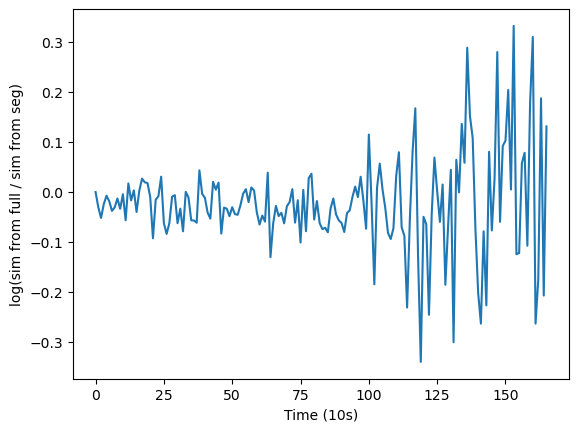

In [11]:
time_simr = np.array(time_simr)
mean_simrs = []
for i in range(30 * 6):
    mean_simrs.append(np.nanmean(time_simr[(time_simr[:, 0] >= i * 10) & (time_simr[:, 0] < (i + 1) * 10), -1]))
plt.plot(mean_simrs)
plt.xlabel('Time (10s)')
plt.ylabel('log(sim from full / sim from seg)')

/tmp/ipykernel_957170/1682408181.py:4: RuntimeWarning: Mean of empty slice.
  mean_sims.append(all_sims[(all_sims[:, 1] >= i * 10) & (all_sims[:, 1] < (i + 1) * 10), -1].mean())
/home/siqiouyang/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/numpy/core/_methods.py:192: invalid value encountered in scalar divide


Text(0, 0.5, 'sim from full')

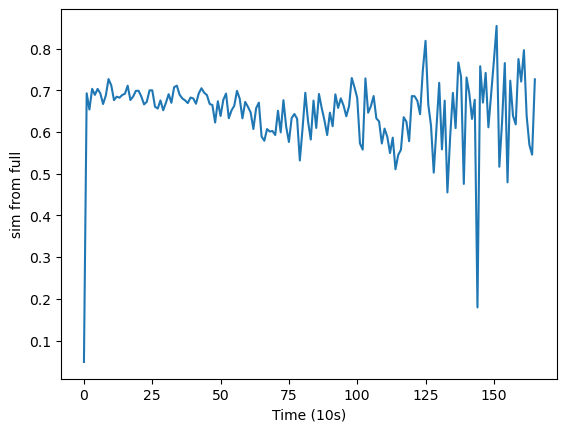

In [12]:
all_sims = np.array(all_sims)
mean_sims = []
for i in range(30 * 6):
    mean_sims.append(all_sims[(all_sims[:, 1] >= i * 10) & (all_sims[:, 1] < (i + 1) * 10), -1].mean())
plt.plot(mean_sims)
plt.xlabel('Time (10s)')
plt.ylabel('sim from full')
# plt.xlabel("Input Length (unit: 10 seconds)")
# plt.ylabel("Cosine Similarity of Speech and Text Embeddings")
# plt.savefig("/home/siqiouyang/work/projects/sllama/notebooks/length_extrapolation.png")

In [3]:
df = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/train_st_de_full_mfa_llama3.tsv")

In [5]:
(df['n_frames'] >= 15 * 60 * 16000).sum()

865

In [6]:
save_df_to_tsv(df[df['n_frames'] >= 15 * 60 * 16000], "/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/train_st_de_full_15min_mfa_llama3.tsv")

# New Speech Encoder

In [1]:
import torch
cfgs = [(1024, 10, 5)] + [(1024, 3, 2)] * 4 + [(1024,2,2)] * 4

In [2]:
import sys
sys.path.append('/home/siqiouya/work/sllama')
from model.speech_encoder import ConvFeatureExtractionModel
feature_extractor = ConvFeatureExtractionModel(cfgs)

/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:309: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


[2024-11-12 17:22:27,194] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [18]:
x1 = torch.rand(1, 79 + 1280 * 2)
x2 = torch.cat([x1, torch.rand(1, 1280)], dim=1)

In [21]:
y1 = feature_extractor(x1)
y2 = feature_extractor(x2)

In [24]:
(y1[0, :, 0] - y2[0, :, 0]) / y1[0, :, 0].abs()

tensor([-5.3082e-06, -8.7828e-08,  0.0000e+00,  ..., -2.0265e-07,
        -2.2166e-06,  5.4623e-07], grad_fn=<DivBackward0>)

In [ ]:
def get_feat_extract_output_lengths(input_lengths):
    """
    Computes the output length of the convolutional layers
    """

    def _conv_out_length(input_length, kernel_size, stride):
        return torch.floor((input_length - kernel_size) / stride + 1)

    for cfg in cfgs:
        input_lengths = _conv_out_length(
            input_lengths, cfg[1], cfg[2]
        )

    return input_lengths.to(torch.long)

In [ ]:
out_lens = get_feat_extract_output_lengths(torch.arange(0, 160000))

In [27]:
t = []
for i in range(len(out_lens) - 1):
    if out_lens[i] != out_lens[i + 1]:
        t.append(i)

In [29]:
t = torch.tensor(t)

In [33]:
get_feat_extract_output_lengths(torch.tensor([80]))

tensor([0])

In [26]:
from x_transformers.x_transformers import RotaryEmbedding

In [28]:
emb = RotaryEmbedding(512)

In [40]:
freq, scale = emb(torch.ones(10))

In [41]:
freq.size()

torch.Size([10, 512])

# Llama

In [1]:
import transformers

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("/data/user_data/siqiouya/runs/pretrained/llama-2-7b/hf")

In [5]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer(
    ["Hello", "Hello 1"],
    padding=True,
    padding_side='left',
)

{'input_ids': [[2, 2, 1, 15043], [1, 15043, 29871, 29896]], 'attention_mask': [[0, 0, 1, 1], [1, 1, 1, 1]], 'offset_mapping': [[(0, 0), (0, 0), (0, 0), (0, 5)], [(0, 0), (0, 5), (5, 6), (6, 7)]]}

# Eval

In [2]:
import os
import json
import types
from comet import download_model, load_from_checkpoint

In [3]:
import os
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [4]:
comet_model = load_from_checkpoint("/compute/babel-7-5/siqiouya/xcomet_xxl/snapshots/bad20b47daa64c41a8b29f3d3016be75baf0d7b4/checkpoints/model.ckpt")

Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../compute/babel-7-5/siqiouya/xcomet_xxl/snapshots/bad20b47daa64c41a8b29f3d3016be75baf0d7b4/checkpoints/model.ckpt`
/home/siqiouya/anaconda3/envs/speechllama/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [5]:
data_root = "/compute/babel-14-5/siqiouya/en-zh/"
samples = read_tsv(os.path.join(data_root, "tst-COMMON.tsv"))
srcs = [s["src_text"] for s in samples]

In [6]:
with open("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v2.2/last.ckpt/simul-results/beam1_mult1_ms0/instances.log", "r") as r:
    instances = [json.loads(line) for line in r.readlines()]

In [7]:
comet_data = [
    {
        "src": srcs[i],
        "mt" : instances[i]['prediction'].strip(),
        "ref": instances[i]['reference'].strip()
    }
    for i in range(len(srcs))
]

In [11]:
comet_output = comet_model.predict(comet_data, batch_size=4, gpus=1)

/home/siqiouya/anaconda3/envs/speechllama/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/siqiouya/anaconda3/envs/speechllama/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Predicting DataLoader 0: 100%|██████████| 707/707 [08:23<00:00,  1.40it/s]


In [12]:
comet_output.system_score

0.6820081391392219

In [13]:
offline_results_dir = "/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0-bi/last.ckpt/offline_beam1/tst-COMMON/"

In [25]:
with open(os.path.join(offline_results_dir, 'hyp'), 'r') as f:
    hyps = [l for l in f.readlines() if len(l.split('\t')) > 1]
with open(os.path.join(offline_results_dir, 'ref'), 'r') as f:
    refs = [l for l in f.readlines() if len(l.split('\t')) > 1]

hs = []
rs = []
for hyp, ref in zip(hyps, refs):
    idx = int(hyp.split('\t')[0])
    hs.append((idx, hyp.split('\t')[1].strip()))
    rs.append((idx, ref.split('\t')[1].strip()))

In [26]:
hs = sorted(hs)
rs = sorted(rs)

In [32]:
comet_data_off = [
    {
        "src": srcs[i],
        "mt" : hs[i][1],
        "ref": rs[i][1],
    }
    for i in range(len(srcs))
]

In [34]:
comet_output_off = comet_model.predict(comet_data_off, batch_size=4, gpus=1)
comet_output_off.system_score

/home/siqiouya/anaconda3/envs/speechllama/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/siqiouya/anaconda3/envs/speechllama/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Predicting DataLoader 0: 100%|██████████| 707/707 [07:58<00:00,  1.48it/s]


0.7865275363243394

# tst-COMMON de

In [ ]:
import json
import yaml
import pandas as pd
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.data.audio.audio_utils import (
    get_fbank,
    get_waveform,
    read_from_stored_zip,
    is_npy_data,
    is_sf_audio_data,
    parse_path,
    FEATURE_OR_SF_AUDIO_FILE_EXTENSIONS,
)

In [32]:
def get_features_or_waveform(
        path: str,
):
    import soundfile as sf
    _path, slice_ptr = parse_path(path)
    if len(slice_ptr) == 0:
        waveform, sample_rate = sf.read(_path, dtype="float32",)
    elif len(slice_ptr) == 2:
        waveform, sample_rate = sf.read(_path, dtype="float32",
                                start=int(slice_ptr[0]), frames=int(slice_ptr[1]))
    else:
        raise ValueError(f"Invalid path: {_path}")
    return waveform, sample_rate

In [2]:
with open('alignatt_instances.log', 'r') as r:
    instances = [json.loads(l) for l in r.readlines() if l.strip() != '']

In [4]:
instances[0]['reference']

'Zu Hause in New York, bin ich Chef der Entwicklungsabteilung einer gemeinnützigen Organisation namens Robin Hood.'

In [6]:
df = load_df_from_tsv('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/tst-COMMON.tsv')

In [15]:
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.yaml', 'r') as r:
    manifest = yaml.safe_load(r)
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.en', 'r') as r:
    src_text = [l.strip() for l in r.readlines() if l.strip() != '']
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.de', 'r') as r:
    tgt_text = [l.strip() for l in r.readlines() if l.strip() != '']

In [26]:
manifest[0]

{'duration': 4.069999,
 'offset': 12.61,
 'speaker_id': 'spk.1096',
 'wav': 'ted_1096.wav'}

In [25]:
df[:1]

id                                              audio  n_frames  \
0  ted_1096_0  /data/user_data/siqiouya/dataset/must-c-v1.0/e...    149440   

    speaker                                           src_text  \
0  spk.1096  "I need you to go upstairs, past the fire, and...   

                                            tgt_text src_lang tgt_lang  \
0  "Sie müssen nach oben gehen, an dem Feuer vorb...       en       de   

                                         src_phoneme  
0  ▁AY1 ▁N IY1 D ▁Y UW1 ▁T UW1 ▁G OW1 ▁AH0 P S T ...

In [27]:
df['audio'][0]

'/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/wav/ted_1096.wav:1621280:149440'

In [41]:
columns = df.columns
columns[:-1]

Index(['id', 'audio', 'n_frames', 'speaker', 'src_text', 'tgt_text',
       'src_lang', 'tgt_lang'],
      dtype='object')

In [42]:
new_df = pd.DataFrame(columns=df.columns[:-1])

In [43]:
cnt = 0
ids = []
audios = []
n_frames = []
speakers = []
for i in range(len(manifest)):
    if i > 0 and manifest[i]['wav'] != manifest[i - 1]['wav']:
        cnt = 0

    wav = manifest[i]['wav']
    ids.append(wav.split('.')[0] + '_{}'.format(cnt))
    offset_frame = int(manifest[i]['offset'] * 16000)
    duration_frame = int(manifest[i]['duration'] * 16000)
    audio = "/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/wav/{}:{}:{}".format(wav, offset_frame, duration_frame)
    audios.append(audio)
    n_frames.append(duration_frame)
    speakers.append(manifest[i]['speaker_id'])

    cnt += 1

In [44]:
new_df['id'] = ids
new_df['audio'] = audios
new_df['n_frames'] = n_frames
new_df['speaker'] = speakers
new_df['src_text'] = src_text
new_df['tgt_text'] = tgt_text
new_df['src_lang'] = ['en'] * len(src_text)
new_df['tgt_lang'] = ['de'] * len(tgt_text)

In [47]:
save_df_to_tsv(new_df, '/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/tst-COMMON.tsv')

# Per 10s Dataset

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torchaudio

In [22]:
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.source', 'r') as r:
    sources = np.array([line.strip() for line in r.readlines() if line.strip() != ""])
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.target', 'r') as r:
    targets = np.array([line.strip() for line in r.readlines() if line.strip() != ""])

In [5]:
n_frames = np.array([torchaudio.info(src).num_frames for src in tqdm(sources)])

  0%|          | 0/2449 [00:00<?, ?it/s]

In [7]:
durations = n_frames / 16000

In [26]:
for duration in [10, 20, 30, 40, 50, 60]:
    source = sources[(duration - 1 < durations) & (durations < duration + 1)][0]
    target = targets[(duration - 1 < durations) & (durations < duration + 1)][0]
    with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON-profile-{}s.source'.format(duration), 'w') as w:
        w.write('\n'.join([source] * 5))

    with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON-profile-{}s.target'.format(duration), 'w') as w:
        w.write('\n'.join([target] * 5))

# Computation Overhead

In [9]:
import json
import numpy as np

In [76]:
path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8-recomp-w2v2/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8-recomp-llm/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage2-bi-mix-fix/simul-results/30s-wait-k-word-1000ms-n3-bsz8/wait-1000ms-2/instances.log"

In [77]:
instances = []
with open(path, 'r') as r:
    for line in r.readlines():
        line = line.strip()
        if line != "":
            instances.append(json.loads(line))

In [67]:
sum = n = m = 0
for ist in instances:
    elapsed = np.array(ist['elapsed'])
    delays = np.array(ist['delays'])
    src_len = ist['source_length']
    elapsed = elapsed[delays < src_len]
    if len(elapsed) > 0:
        sum += elapsed[-1]
        n += len(elapsed)

        # sum += ist['elapsed'][-1]
        # n += len(ist['elapsed'])
    else:
        m += 1
print(sum / n, m)

621.8687562341071 3


In [68]:
ist['elapsed']

[2287.7461910247803,
 2287.7461910247803,
 2287.7461910247803,
 3655.0493240356445,
 3655.0493240356445,
 3655.0493240356445,
 5002.168416976929,
 5002.168416976929,
 5002.168416976929,
 6394.201755523682,
 6394.201755523682,
 6394.201755523682,
 7763.236045837402,
 7763.236045837402,
 7763.236045837402,
 9167.474508285522,
 9167.474508285522,
 9167.474508285522,
 10611.480951309204,
 10611.480951309204,
 10611.480951309204,
 12029.924154281616,
 12029.924154281616,
 12029.924154281616,
 13561.732769012451,
 13561.732769012451,
 13561.732769012451,
 15061.572790145874,
 15061.572790145874,
 15061.572790145874,
 16594.61998939514,
 16594.61998939514,
 16594.61998939514,
 18212.515354156494,
 18212.515354156494,
 18212.515354156494,
 19794.62242126465,
 19794.62242126465,
 19794.62242126465,
 21457.502365112305,
 21457.502365112305,
 21457.502365112305,
 23102.35023498535,
 23102.35023498535,
 23102.35023498535,
 24903.220176696777,
 24903.220176696777,
 24903.220176696777,
 26774.255037

# en-de

In [2]:
from IPython.display import Audio
from train.dataset import get_features_or_waveform

[2024-06-07 09:24:51,281] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
wav = get_features_or_waveform("/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/data/tst-COMMON/wav/ted_1096.wav:201760:1816160")
Audio(wav[0], rate=wav[1])

# Previous

In [1]:
import os
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

[2024-05-02 12:27:04,989] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dirname = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es'
split = 'train_mfa'
df = load_df_from_tsv(os.path.join(dirname, split + '.tsv'))
# new_paths = []
# for a in df['audio']:
#     new_paths.append('/scratch/siqiouya/dataset/must-c-v1.0/' + a)
# df['audio'] = new_paths
# save_df_to_tsv(df, os.path.join(dirname, split + '.tsv'))

In [10]:
df[df['text_word'] == '']

id                                              audio  \
11          ted_1_11  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
19          ted_1_19  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
20          ted_1_20  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
22          ted_1_23  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
24          ted_1_25  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
...              ...                                                ...   
259948  ted_12908_51  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
259949  ted_12908_52  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
259967  ted_12908_72  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
260028  ted_13591_32  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   
260033  ted_13591_37  /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...   

        n_frames    speaker  \
11        137600      spk.1   
19        228960      spk.1   
20        279200      spk.1   
22          3040      spk.1   
24        175840      spk.1   
...          ...        ...   
259948      1120  spk.12908   
259949      8160  spk.12908   
259967     85440  spk.12908   
260028    206880  spk.13591   
260033      2240  spk.13591   

                                                 src_text  \
11      And I told it pretty much the same way I've ju...   
19      (Laughter) And the story began, "Former Vice P...   
20      (Laughter) Before I could get back to U.S. soi...   
22                Chris Anderson: It's a deal! (Applause)   
24      I want to start with a couple of — I'm going t...   
...                                                   ...   
259948                                         (Laughter)   
259949                                        That said —   
259967  And you should know that this idea, this hope ...   
260028  If women have led countries, women have gone t...   
260033                                (Metallic drumming)   

                                                 tgt_text src_lang tgt_lang  \
11      Y la conté bastante del mismo modo en que la a...       en       es   
19      Y la historia comenzaba, "El ex vicepresidente...       en       es   
20      Antes de que pudiera regresar a suelo norteame...       en       es   
22                          Chris Anderson: ¡Es un trato!       en       es   
24      Quiero empezar con — voy a mostrar unas nuevas...       en       es   
...                                                   ...      ...      ...   
259948                                            (Risas)       en       es   
259949                                     El tuit decía:       en       es   
259967  Y debo decir que esta idea, esta esperanza, no...       en       es   
260028  Si hay mujeres que han liderado países, que ha...       en       es   
260033                     (Sonido de platillos de metal)       en       es   

       speech_word text_word  
11                            
19                            
20                            
22                            
24                            
...            ...       ...  
259948                        
259949                        
259967                        
260028                        
260033                        

[28984 rows x 10 columns]

# Debug Train

In [ ]:
update_config = os.path.join(, 'config_large.json')

# Change path of tsv

In [4]:
import os
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

In [2]:
dev = 'train'

In [5]:
df = load_df_from_tsv(os.path.join('/scratch/siqiouya/dataset/must-c-v1.0/en-es/', '{}.tsv'.format(dev)))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/siqiouya/dataset/must-c-v1.0/en-es/train.tsv'

# Mask

In [1]:
import torch

In [2]:
def generate_2d_causal_mask(seq_len, dtype, device='gpu', blocksize=1):
    """
    Generates a 2D causal mask for multi-head attention.
    
    Args:
        seq_len (int): The length of the sequence.
        dtype (torch.dtype): The data type for the mask.
        device (str): The device on which to create the mask.
    
    Returns:
        torch.Tensor: A 2D causal attention mask.
    """
    blocksizes = [min(blocksize, seq_len - i * blocksize) for i in range((seq_len + blocksize - 1) // blocksize)]
    blocks = [torch.ones((s, s), device=device, dtype=dtype) for s in blocksizes]
    mask = torch.block_diag(*blocks)

    tril_row, tril_col = torch.tril_indices(seq_len, seq_len)
    mask[tril_row, tril_col] = 1

    mask.masked_fill_(mask == 0, float('-inf'))
    mask.masked_fill_(mask == 1, 0)

    return mask

In [3]:
generate_2d_causal_mask(6, float, device='cpu', blocksize=4)

tensor([[0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

# mfa_30s_mix_filtered

In [2]:
import torchaudio

In [3]:
train_df = load_df_from_tsv("/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/train_mfa_30s_mix_filtered.tsv")

In [13]:
train_df.iloc[231870]

id                                                 30s_ted_25_41
audio          /scratch/siqiouya/dataset/must-c-v1.0/en-es/da...
n_frames                                                  469921
speaker                                                   spk.26
src_text       So I'd just like to end by saying: you can rea...
tgt_text       Así que quisiera terminar diciendo, que ustede...
src_lang                                                      en
tgt_lang                                                      es
speech_word    [(0.0, 0.12), (0.12, 0.18), (0.18, 0.25), (0.2...
text_word      [(0, 0), (1, 1), (3, 3), (4, 4), (5, 5), (6, 6...
Name: 231870, dtype: object

In [11]:
print(torchaudio.info("/scratch/siqiouya/dataset/must-c-v1.0/en-es/data/train/wav/ted_26.wav"))

AudioMetaData(sample_rate=16000, num_frames=3857750, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [12]:
17256479
3857750

17256479

# tst-COMMON_30s

In [12]:
import os
import torchaudio
import IPython.display
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

In [25]:
ori_path = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.tsv'
long_path = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON_st_es_30s.tsv'

In [26]:
ori_df = load_df_from_tsv(ori_path)
long_df = load_df_from_tsv(long_path)

In [31]:
ori_df.iloc[19]

id                                                ted_1096_22
audio       /data/user_data/siqiouya/dataset/must-c-v1.0/e...
n_frames                                                89120
speaker                                              spk.1096
src_text    But still it was a real footrace against the o...
tgt_text    Pero aún así hubo una carrera a pie contra los...
src_lang                                                   en
tgt_lang                                                   es
Name: 19, dtype: object

In [10]:
def read_wav(path):
    path, offset, duration = path.split(':')
    wav, _ = torchaudio.load(path, int(offset), int(duration))
    return wav

In [38]:
IPython.display.Audio(read_wav(ori_df['audio'][19]), rate=16000)

In [37]:
ori_df['src_text'][19]

'But still it was a real footrace against the other volunteers to get to the captain in charge to find out what our assignments would be.'

# COMET

In [1]:
import os
import json
import types
from comet import download_model, load_from_checkpoint
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv

ModuleNotFoundError: No module named 'fairseq'

In [ ]:
comet_model = load_from_checkpoint("/data/user_data/siqiouya/runs/pretrained/models--Unbabel--XCOMET-XXL/snapshots/bad20b47daa64c41a8b29f3d3016be75baf0d7b4/checkpoints")

: 

In [5]:
df = load_df_from_tsv('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON_30s.tsv')
src_texts = df['src_text'].tolist()

In [6]:
paths = [
    '/data/user_data/siqiouya/runs/stage3-uni-waco-word-block16-fixed-mix-from-stage0-l40/simul-results/30s-wait-k-word-inc-opt-bsz8/wait-320ms-13/',
    '/data/user_data/siqiouya/runs/stage2-bi-mix-fix/simul-results/30s-wait-k-word-bsz8/wait-320ms-13/'
]

In [10]:
for path in paths:
    instances = []
    instances_log_path = os.path.join(path, 'instances.log')
    hyps = []
    refs = []
    with open(instances_log_path, 'r') as r:
        for line in r.readlines():
            line = line.strip()
            if line != '':
                d = json.loads(line)
                instance = types.SimpleNamespace(**d)
                hyps.append(instance.prediction)
                refs.append(instance.reference)
    comet_data = [
        {
            "src": src_texts[i],
            "mt" : hyps[i],
            "ref": refs[i]
        }
        for i in range(len(hyps))
    ]
    comet_output = comet_model.predict(comet_data[:10], batch_size=7, gpus=1)
    break

/home/siqiouya/anaconda3/envs/sllama_lightning/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/siqiouya/anaconda3/envs/sllama_lightning/lib/p ...


ImportError: libmpi.so.40: cannot open shared object file: No such file or directory